# Introduction

This program will take a sample target from the given COSMOS mosaic tile and smooth the object.
It will smooth as a function of the FWHM that is inputted.
Then it will graph the smoothed object and overplot the Mini-IFUs onto the smoothed target

#### Please Note that plotting in python has y axis starting from the top down

First we need to CD to the proper directory

In [1]:
cd /Users/RichardP/Research/FOBOS/py_FOBOS/

/Users/RichardP/Research/FOBOS/py_FOBOS


# Un-Smoothed

First we will look at an unsmoothed object with magnitude between 22.5 - 24.5. We also find the integrated flux, each Mini_IFU flux, and the I-mag in that order

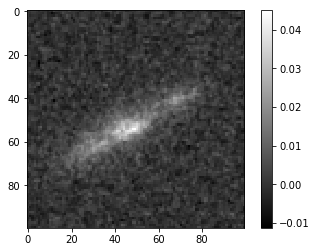

[4.6434558815089986, 0.51546733987561311, 0.70814347663099397, 3.6147450993667007, 0.6309635242719196, 0.2624930350511363, 2.2665572960340796]
12.641825652739442


In [2]:
run flux_value.py

# Graphing

We will now call the script and graph a random target within the magnitude range 22.5 - 24.5. 

In [8]:
run smoothing.py

We will plot .5 arcsecond to 1.5 arcsecond smoothed images now with intervals of .25 arcseconds

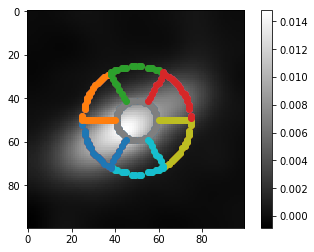

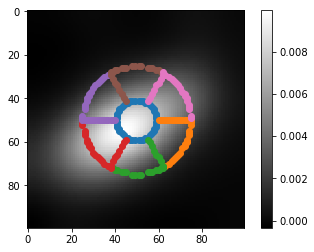

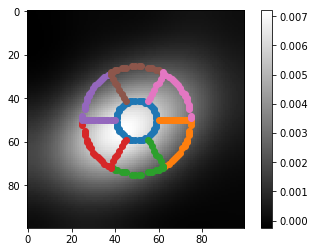

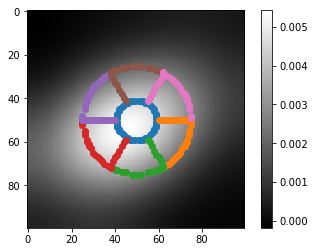

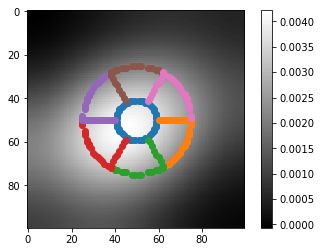

In [9]:
smoothing(.5)
smoothing(.75)
smoothing(1.0)
smoothing(1.25)
smoothing(1.5)

# Calculations

Now we want the data from the object.
The script, smooth_flux, will give us the flux and magnitudes of the target and the 7 Mini-IFUs.

In [17]:
run smooth_flux.py

Now we want to find the values of a .5 arcsecond smoothed object.
We use the function smooth_flux(FWHM).
The function will compile the data into lists.
IFU_flux and IFU_sum.
IFU_flux outputs the flux from 0-6 of the Mini-IFUs
0 is the center IFU and starting looking at the image above 1 is the Orange IFU counting clockwise
IFU_sum is the integrated flux of all the objects

In [18]:
smooth_flux(.5)
smooth_flux(.75)
smooth_flux(1.0)
smooth_flux(1.25)
smooth_flux(1.5)

[4.638276028446853, 0.4942835093993381, 0.7019967608175648, 3.5707010579062626, 0.6143786259508488, 0.26901221002276543, 2.263091066852212]
[12.551739259395845]
[4.612426529172808, 0.483151738363631, 0.7009716744919388, 3.551967127597891, 0.6105465083984427, 0.2724119320776026, 2.2598793018842116]
[12.491354811986525]
[4.583238779567182, 0.47271480039762537, 0.7023696227697656, 3.532671581604518, 0.6057479406881612, 0.2760023392770563, 2.2563360353233293]
[12.429081099627638]
[4.556265742518008, 0.46335114626072027, 0.7050263857236132, 3.512972065480426, 0.6005901312746573, 0.27958856843940794, 2.2520517623052]
[12.369845802002033]
[4.533226957544684, 0.4549906898246263, 0.7082265829667449, 3.4926709334831685, 0.595506797748385, 0.2831523946364314, 2.2466637364123017]
[12.314438092616342]


## Extra

Since COSMOS ACS Field was taken in the I-Band here is the code to convert the flux to ABmag. 

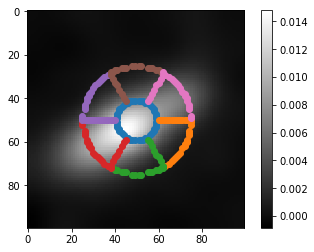

In [27]:
smoothing(.5)

[4.638276028446853, 0.4942835093993381, 0.7019967608175648, 3.5707010579062626, 0.6143786259508488, 0.26901221002276543, 2.263091066852212]
[12.551739259395845]


NameError: name 'IFU_sum' is not defined